In [1]:
import cv2
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.optimizers import SGD
import numpy as np
import random
import os

### Load Images and Annotations

In [2]:
df = pd.read_csv('./data/legend.csv')
del df['user.id']

In [3]:
df

,image,emotion
0,facial-expressions_2868588k.jpg,anger
1,facial-expressions_2868585k.jpg,surprise
2,facial-expressions_2868584k.jpg,disgust
3,facial-expressions_2868582k.jpg,fear
4,Aaron_Eckhart_0001.jpg,neutral
...,...,...
13685,SharmilaTagore_80.jpg,HAPPINESS
13686,SharmilaTagore_81.jpg,HAPPINESS
13687,SharmilaTagore_82.jpg,HAPPINESS
13688,SharmilaTagore_83.jpg,HAPPINESS


In [4]:
#get a list of all the images file paths and cooresponding emotions annotations

all_paths = []
all_emotion = []
for index, row in df.iterrows():
    name = row['image']
    emotion = row['emotion']
    all_paths.append(name)
    all_emotion.append(emotion.lower())

### Process Images

In [5]:
#function for loading and resize image to 64x64x3

def load_and_process(val):
    path = './images/' + val
    im = cv2.imread(path)
    im_small = cv2.resize(im, (48, 48), interpolation=cv2.INTER_LINEAR)
    return im_small

In [6]:
#load all images

images = [load_and_process(path) for path in all_paths]

### Example Data

'anger'

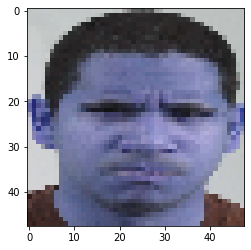

In [7]:
#example

plt.imshow(images[0])
all_emotion[0]

### Dataset Info

In [8]:
dataset_size = len(df)

expressions = []
freq_table = dict()
for val in df['emotion']:
    val = val.lower()
    expressions.append(val)
    
    if freq_table.get(val):
        freq_table[val] += 1
    else:
        freq_table[val] = 1
    
expressions = list(set(expressions))

print('Images:', dataset_size)
print('Expression Types:', expressions)

Images: 13690
Expression Types: ['anger', 'surprise', 'sadness', 'contempt', 'fear', 'happiness', 'disgust', 'neutral']


### Distribution of Expressions in the Facial Expression Dataset

<BarContainer object of 8 artists>

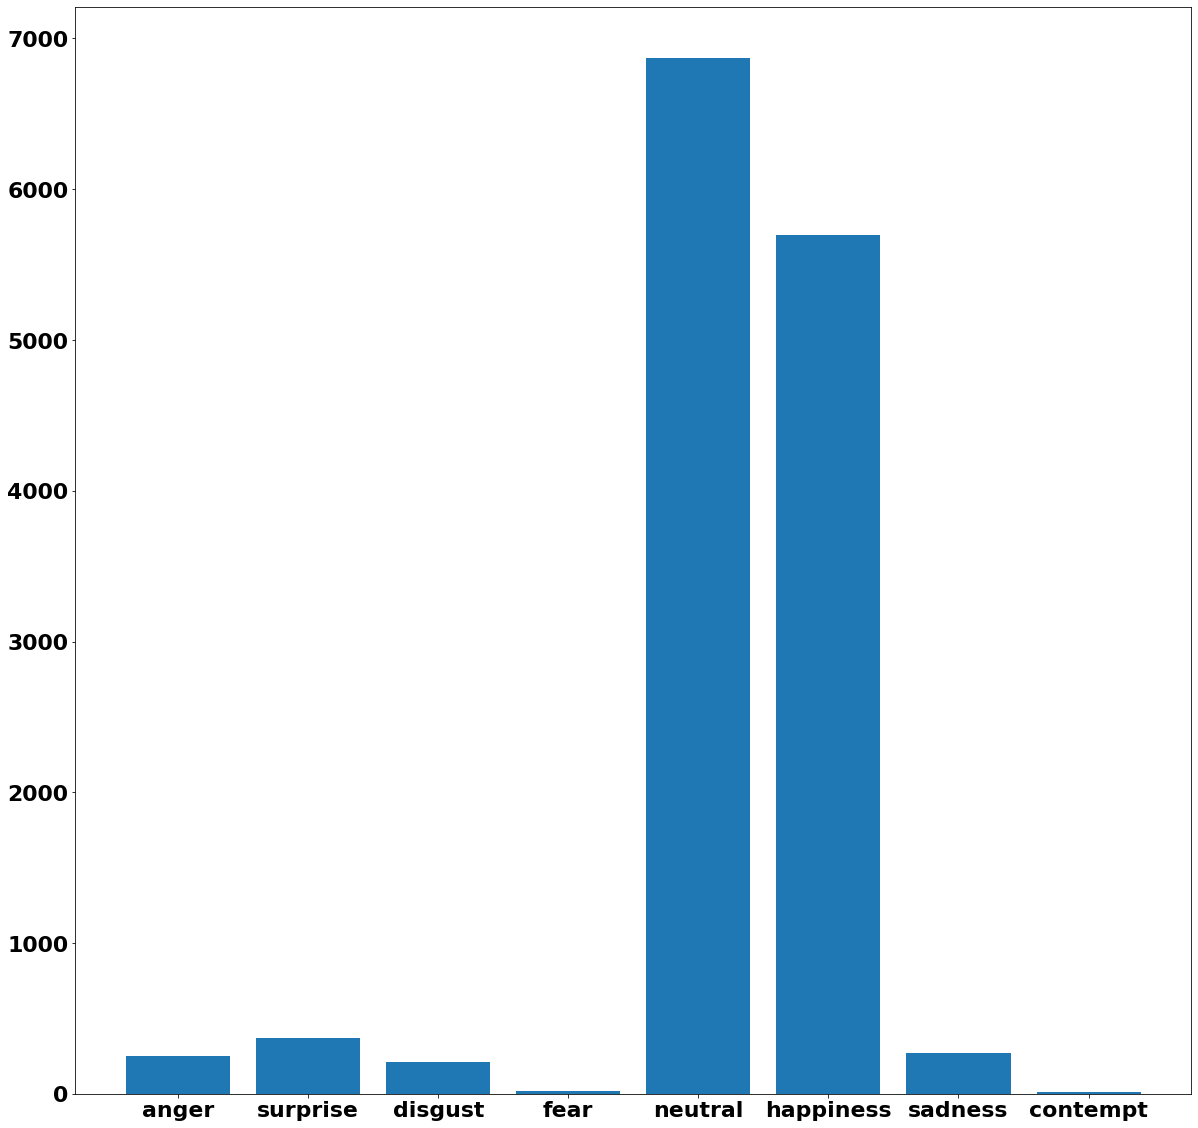

In [9]:
font = {'weight':'bold','size':22}
matplotlib.rc('font', **font)
plt.figure(figsize=(20, 20))
plt.bar(freq_table.keys(), freq_table.values())

### Encode and Shuffle Data

In [10]:
#encoded textual annotation to a unique integer
#group and randomized image-annotation pairs

encoded = []
encode_emotion = {'happiness':1, 'contempt':2, 'neutral':3, 'disgust':4, 'fear':5, 'anger':6, 'surprise':7, 'sadness':8}
for image, emotion in zip(images, all_emotion):
    np_image = np.array(image)
    np_emotion = [encode_emotion[emotion]]
    encoded.append([np_image, np_emotion])

random.shuffle(encoded)

### Split Data

In [11]:
#80% for training | 20% for testing

x_test = []
y_test = []

x_train = []
y_train = []

split_idx = round(len(encoded) * 0.1)

for i in range(len(encoded)):
    image = encoded[i][0]
    emotion = encoded[i][1]
    if i <= split_idx:
        x_test.append(image)
        y_test.append(emotion)
    else:
        x_train.append(image)
        y_train.append(emotion)

In [12]:
#format to input into model

x_test = np.array(x_test)
y_test = np.array(y_test)

x_train = np.array(x_train)
y_train = np.array(y_train)

In [13]:
#one-hots encoding of integer representation of emotion annotation

y_test_hots = to_categorical(y_test)
y_train_hots = to_categorical(y_train)

In [14]:
#normalize images

x_test = x_test / 255
x_train = x_train / 255

In [15]:
x_test.shape

(1370, 48, 48, 3)

### Model

In [16]:
#define ideal model architecture

def create_model():
    #architecture
    model = Sequential()

    #convolution layer - 1
    model.add(Conv2D(48, (5,5), activation='relu', input_shape=(48,48,3)))

    #pooling layer - 2
    model.add(MaxPooling2D(pool_size = (2,2)))

    #convolution layer - 3
    model.add(Conv2D(48, (5,5), activation='relu'))

    #pooling layer - 4
    model.add(MaxPooling2D(pool_size = (2,2)))

    #flattening layer - 5
    model.add(Flatten())

    #neuron layer - 6
    model.add(Dense(1000, activation='relu'))

    #dropout layer - 7
    model.add(Dropout(0.5))

    #neuron layer - 8
    model.add(Dense(500, activation='relu'))

    #dropout layer - 9
    model.add(Dropout(0.5))

    #neuron layer - 10
    model.add(Dense(250, activation='relu'))

    #neuron layer - 11
    model.add(Dense(9, activation='softmax'))
    
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    return model

In [17]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 44, 44, 48)        3648      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 48)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 18, 48)        57648     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 48)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3888)              0         
_________________________________________________________________
dense (Dense)                (None, 1000)              3889000   
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0

### Train and Save

In [18]:
#Train model then save weights

checkpoint_path = "saved_model_curr/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose=1)
hist = model.fit(x_train, y_train_hots, batch_size = 256, epochs = 30, validation_split = 0.1, callbacks = [cp_callback])

Epoch 1/30
44/44 [==============================] - ETA: 0s - loss: 1.1508 - accuracy: 0.4499
Epoch 00001: saving model to saved_model_curr\cp.ckpt
44/44 [==============================] - 8s 175ms/step - loss: 1.1508 - accuracy: 0.4499 - val_loss: 0.9963 - val_accuracy: 0.5114
Epoch 2/30
44/44 [==============================] - ETA: 0s - loss: 1.0147 - accuracy: 0.4967
Epoch 00002: saving model to saved_model_curr\cp.ckpt
44/44 [==============================] - 10s 238ms/step - loss: 1.0147 - accuracy: 0.4967 - val_loss: 0.9686 - val_accuracy: 0.5195
Epoch 3/30
44/44 [==============================] - ETA: 0s - loss: 0.9481 - accuracy: 0.5795
Epoch 00003: saving model to saved_model_curr\cp.ckpt
44/44 [==============================] - 10s 227ms/step - loss: 0.9481 - accuracy: 0.5795 - val_loss: 0.7884 - val_accuracy: 0.7037
Epoch 4/30
44/44 [==============================] - ETA: 0s - loss: 0.7201 - accuracy: 0.7519
Epoch 00004: saving model to saved_model_curr\cp.ckpt
44/44 [======

Epoch 30/30
44/44 [==============================] - ETA: 0s - loss: 0.0625 - accuracy: 0.9774
Epoch 00030: saving model to saved_model_curr\cp.ckpt
44/44 [==============================] - 8s 173ms/step - loss: 0.0625 - accuracy: 0.9774 - val_loss: 1.0557 - val_accuracy: 0.8369


### Model Performance

In [22]:
model = create_model()
loss, acc = model.evaluate(x_test, y_test_hots)
print('untrained model, accuracy: {:5.2f}%'.format(100*acc))

43/43 [==============================] - 0s 6ms/step - loss: 2.1945 - accuracy: 0.0219
untrained model, accuracy:  2.19%


In [23]:
model.load_weights(checkpoint_path)
loss, acc = model.evaluate(x_test, y_test_hots)
print('trained model, accuracy: {:5.2f}%'.format(100*acc))

43/43 [==============================] - 0s 6ms/step - loss: 1.0002 - accuracy: 0.8387
trained model, accuracy: 83.87%


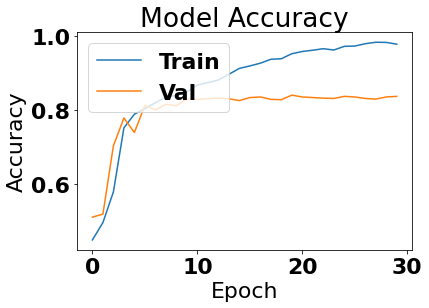

In [24]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

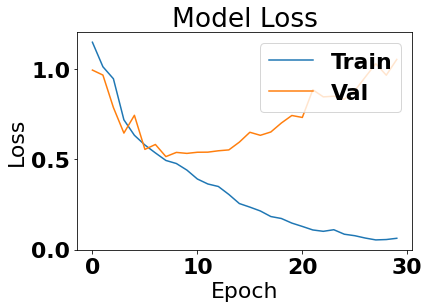

In [25]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

### Demo

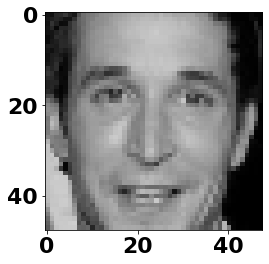

In [39]:
test_img = x_test[708]
plt.imshow(test_img)

In [40]:
#get results from model for this image

predictions = model.predict(np.array([test_img]))
predictions

array([[5.6246646e-22, 9.9999964e-01, 1.4480474e-15, 3.6694649e-07,
        8.5276390e-14, 7.0183946e-17, 4.9855140e-15, 9.3625423e-15,
        1.8442077e-13]], dtype=float32)

In [41]:
#decode prediction

decode = {1:'happiness', 2:'contempt', 3:'neutral', 4:'disgust', 5:'fear', 6:'anger', 7:'surprise', 8:'sadness'}
list_idx = [1,2,3,4,5,6,7,8]
x = predictions

for i in range(len(list_idx)):
    for j in range(len(list_idx)):
        if x[0][list_idx[i]] > x[0][list_idx[j]]:
            temp = list_idx[i]
            list_idx[i] = list_idx[j]
            list_idx[j] = temp
            
print(list_idx)

[1, 3, 8, 4, 7, 6, 2, 5]


In [42]:
for i in range(len(list_idx)):
    print(decode[list_idx[i]],':', round(predictions[0][list_idx[i]] * 100, 2), '%')

happiness : 100.0 %
neutral : 0.0 %
sadness : 0.0 %
disgust : 0.0 %
surprise : 0.0 %
anger : 0.0 %
contempt : 0.0 %
fear : 0.0 %


References:
    - Classify Images Using Python & Machine Learning - Computer Science, https://www.youtube.com/watch?v=iGWbqhdjf2s